In [17]:
import torch
import torchaudio
import torch.nn as nn
import torchaudio.transforms as trans 
import torchaudio.functional as func

from IPython.display import Audio

In [32]:
trainset = torchaudio.datasets.VCTK(root='./code/pytorch_datasets', 
                                    downsample=False,
                                    download=True,
                                    dev_mode=True)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=1,
                                          shuffle=True,
                                          num_workers=1)

def tokenize(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]


def audio_set_iterator():
    for example in trainset:
        yield tokenize(example[1])

In [33]:
import torch.optim as optim
import numpy as np

from torchtext.vocab import Vocab
from torchtext.vocab import build_vocab_from_iterator

import spacy

import random
import math
import time

import spacy.cli
spacy.cli.download("en")
spacy_en = spacy.load('en')

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/home/tarek/anaconda3/envs/audio/lib/python3.7/site-packages/en_core_web_sm -->
/home/tarek/anaconda3/envs/audio/lib/python3.7/site-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [4]:
vocab = build_vocab_from_iterator(audio_set_iterator())

33867lines [00:45, 742.95lines/s]


In [20]:
for i in range(10):
    print(vocab.itos[i])
    
print(len(vocab))

<unk>
<pad>
.


the
a
,
is
to
was
6087


In [38]:
import matplotlib.pyplot as plt 
from torch.autograd import Variable
import numpy as np


import torchaudio.functional as func

class Parser(nn.Module):
    
    def __init__(self, sample_rate, temp_res_spec, freq_res_spec, 
                conv_features, temp_res_enc, y_dim_enc):
        """
        sample_rate: sample rate of the audio input
        
        temp_res_spec: temporal resolution (in slices per second) of the 
            spectrogram that is performed on the audio clip
        
        freq_res_spec: frequency resolution (in total number of slices)
            of the spectrogram that is performed on the audio clip
            
        temp_res_enc: the temporal resolution (again in slices / sec) of 
            of the encoded signal that is returned from this object
            
        y_dim_enc: the number of elements in the second dimension of the 
            encoded signal, i.e. the length of the vectors at each time slice
            
        """
        
        super().__init__()
        
        self.sample_rate = sample_rate
        self.temp_res_spec = temp_res_spec
        self.freq_res_spec = freq_res_spec
        self.temp_res_enc = temp_res_enc
        self.y_dim_enc = y_dim_enc
        self.conv_features = conv_features
        
        self.freq_res_trimmed = round(self.freq_res_spec * 0.35)
        
        self.conv_width = round(temp_res_spec / temp_res_enc)
        print(f'conv width is {self.conv_width}')
        
        
        conv_height1 = round(self.freq_res_trimmed / 3)
        kernel_size1 = (self.conv_width, conv_height1)
        padding_size1 = (0, conv_height1 - 1)
        stride_size1 = (self.conv_width, round(conv_height1 / 3))
        
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels=conv_features,
                                kernel_size=kernel_size1, 
                                padding=padding_size1,
                                stride=stride_size1)
        
        conv_height2 = round(self.freq_res_trimmed / 13)
        kernel_size2 = (self.conv_width, conv_height2)
        padding_size2 = (0, conv_height2 - 1)
        stride_size2 = (self.conv_width, round(conv_height2 / 13))
        
        self.conv2 = nn.Conv2d(in_channels=1, out_channels=conv_features,
                                kernel_size=kernel_size2,
                                padding=padding_size2,
                                stride=stride_size2)
                
        with torch.no_grad():
            self.out_size1 = self.conv1(torch.ones(1, 1, self.temp_res_spec,
                                            self.freq_res_trimmed)).size()
            
            self.out_size2 = self.conv2(torch.ones(1, 1, self.temp_res_spec, 
                                              self.freq_res_trimmed)).size()
            
            print(f'out 1 size should be {self.out_size1}')
            print(f'out 2 size should be {self.out_size2}')

        
        linear_input_size = self.out_size1[3] + self.out_size2[3]
        self.linear1 = nn.Linear(linear_input_size, 128)
        
        self.linear2 = nn.Linear(self.conv_features, 1)
        
        self.gru = nn.GRU(input_size=128, hidden_size=16, bidirectional=True)
        
        self.cel = nn.LSTMCell(input_size=32, hidden_size=16)
        
        self.linear3 = nn.Linear(32, 4)
        
        

    def forward(self, x):
        window_size = self.freq_res_spec
        naud = x.size()[1]
        nsec = (naud / self.sample_rate)
        print(f'nsec is {nsec}')
        nspec = nsec * self.temp_res_spec
        hop = round(naud / nspec)
        
        spec = func.spectrogram(
                sig=x, 
                pad=0, window=torch.bartlett_window(window_size), 
                n_fft=round(window_size * 2), hop=hop, 
                ws=window_size, power=2, normalize=False)
        
        
        print(f'spectrogram size is {spec.size()}')
        spec = Variable(spec[:, :, :self.freq_res_trimmed])
        spec = torch.sqrt(spec)
        self.show_graph(spec, x)
        
        print(f'spectrogram size is {spec.size()}')
        spec = spec.unsqueeze(0)
        
        out1 = self.conv1(spec)
        print(out1.size())
        
        out2 = self.conv2(spec)
        print(out2.size())
        
        out3 = torch.cat((out1.squeeze(0), out2.squeeze(0)), dim=2)
        out3 = torch.transpose(out3, 0, 1)
        print(out3.size())
        
        out4 = self.linear1(out3)
        print(out4.size())
        
        out5 = torch.transpose(out4, 1, 2)
        out5 = self.linear2(out5)
        out5 = torch.transpose(out5, 1, 2)
        print(out5.size())
        
        out6 = self.gru(out5)
        print(out6[0].size())
        print(out6[1].size())
        
        words = torch.empty((1, 32, 1))
        words = torch.cat((words, words), 2)
        
        
        cel_state = torch.empty((1, 16))
        nn.init.xavier_uniform_(cel_state)
        hid_state = torch.empty((1, 16))
        nn.init.xavier_uniform_(hid_state)
        
        for s in out6[0]:
            #print(words.size())
            hid_state, cel_state = self.cel(s)
            print(f'hidden size is {hid_state.size()}')
            print(f'cel size is {cel_state.size()}')
            
            cur_state = torch.cat((cel_state, hid_state), dim=1)
            #print(cur_state.size())
            
            res = self.linear3(cur_state)
            res = nn.functional.softmax(res, 1)
            bit = torch.argmax(res)
            if(bit == 3):
                print("NEW WORD")
                print(words.size())
                words = torch.cat((words, cur_state.unsqueeze(2)), dim=2)
                cel_state = torch.empty((1, 16))
                nn.init.xavier_uniform_(cel_state)

                

    def show_graph(self, spec, clip):
        nps = spec.numpy()[0]
        
        S = np.swapaxes(np.abs(nps), 0, 1)

        f, ax = plt.subplots(figsize=(15, 13))

        N = clip.shape[1] 
        L = round(N / self.sample_rate)
        n = L * self.temp_res_spec
        ax.imshow(S[:, :], origin='lower', cmap='viridis',
                  extent=(0, n, 0, round(self.freq_res_trimmed)))

        
        
        

conv width is 12
out 1 size should be torch.Size([1, 25, 83, 12])
out 2 size should be torch.Size([1, 25, 83, 151])
nsec is 6.985159090909091
spectrogram size is torch.Size([1, 6986, 801])
spectrogram size is torch.Size([1, 6986, 280])
torch.Size([1, 25, 582, 12])
torch.Size([1, 25, 582, 151])
torch.Size([582, 25, 163])
torch.Size([582, 25, 128])
torch.Size([582, 1, 128])
torch.Size([582, 1, 32])
torch.Size([2, 1, 16])
hidden size is torch.Size([1, 16])
cel size is torch.Size([1, 16])
hidden size is torch.Size([1, 16])
cel size is torch.Size([1, 16])
hidden size is torch.Size([1, 16])
cel size is torch.Size([1, 16])
hidden size is torch.Size([1, 16])
cel size is torch.Size([1, 16])
hidden size is torch.Size([1, 16])
cel size is torch.Size([1, 16])
hidden size is torch.Size([1, 16])
cel size is torch.Size([1, 16])
hidden size is torch.Size([1, 16])
cel size is torch.Size([1, 16])
hidden size is torch.Size([1, 16])
cel size is torch.Size([1, 16])
hidden size is torch.Size([1, 16])
cel si

hidden size is torch.Size([1, 16])
cel size is torch.Size([1, 16])
hidden size is torch.Size([1, 16])
cel size is torch.Size([1, 16])
hidden size is torch.Size([1, 16])
cel size is torch.Size([1, 16])
hidden size is torch.Size([1, 16])
cel size is torch.Size([1, 16])
hidden size is torch.Size([1, 16])
cel size is torch.Size([1, 16])
hidden size is torch.Size([1, 16])
cel size is torch.Size([1, 16])
hidden size is torch.Size([1, 16])
cel size is torch.Size([1, 16])
hidden size is torch.Size([1, 16])
cel size is torch.Size([1, 16])
hidden size is torch.Size([1, 16])
cel size is torch.Size([1, 16])
hidden size is torch.Size([1, 16])
cel size is torch.Size([1, 16])
hidden size is torch.Size([1, 16])
cel size is torch.Size([1, 16])
hidden size is torch.Size([1, 16])
cel size is torch.Size([1, 16])
hidden size is torch.Size([1, 16])
cel size is torch.Size([1, 16])
hidden size is torch.Size([1, 16])
cel size is torch.Size([1, 16])
hidden size is torch.Size([1, 16])
cel size is torch.Size([1, 

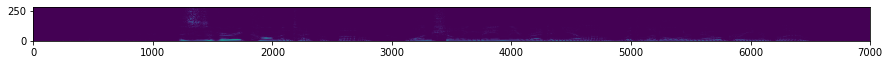

In [40]:
SAMPLE_RATE = 44000
TEMP_RES_SPEC = 1000
FREQ_RES_SPEC = 800
CONV_FEATURES = 25
TEMP_RES_ENC = 80
Y_DIM_ENC = 20

parser = Parser(sample_rate = SAMPLE_RATE,
                temp_res_spec = TEMP_RES_SPEC,
                freq_res_spec = FREQ_RES_SPEC,
                conv_features = CONV_FEATURES,
                temp_res_enc = TEMP_RES_ENC,
                y_dim_enc = Y_DIM_ENC)

#print(trainset[1][0])

#parser(trainset[123][0])
tli = iter(trainloader)
sounds_batch, labels_batch = tli.next()
parser(sounds_batch[0])

print(f'Target was: {labels_batch[0]}')
print(f'Tokenized target was {tokenize(labels_batch[0])}')
print("Target length was {}".format(len(tokenize(labels_batch[0]))))

In [12]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(parser):,} trainable parameters')

The model has 67,166 trainable parameters


In [13]:
class Decoder(nn.Module):
    
    def __init__(self, n_vocab, emb_dim, hid_dim, dropout):
        super().__init__()
        
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.dropout = dropout
        
        self.embedding = nn.Embedding(n_vocab, emb_dim)
        
        self.rnn = nn.GRU(emb_dim, hid_dim)
        
        self.lin = nn.Linear(hid_dim, emb_dim)
        self.out = nn.Linear(emb_dim, n_vocab)
        
        self.nonlinear = nn.Tanh()
        
    def forward(self, input):
        #print(f'input before {input.size()}')
        #print(f'input after {input.size()}')
        
        embedded = self.embedding(input)
        embedded = embedded.unsqueeze(1)
        #print(f'embedded size is {embedded.size()}')
        
        output, hidden = self.rnn(embedded)
        #print(f'hidden size is {hidden.size()}')
        #print(f'output size is {output.size()}')
        prediction = self.lin(output)
        prediction = self.nonlinear(prediction)
        prediction = self.out(prediction)
        #prediction = self.nonlinear(prediction)
        return prediction
        

In [14]:
def token_tensor(text, vocab):
    return torch.tensor([vocab.stoi[tok.text] for tok in spacy_en.tokenizer(text)])

In [15]:
N_VOCAB = len(vocab)
EMB_DIM = 128
HID_DIM = 256
DROPOUT = 0.25

dec = Decoder(n_vocab=N_VOCAB, 
              emb_dim=EMB_DIM, 
              hid_dim=HID_DIM, 
              dropout=DROPOUT)

print(f'The model has {count_parameters(dec):,} trainable parameters')

sounds_batch, labels_batch = iter(trainloader).next()
print(labels_batch[0])
labels = token_tensor(labels_batch[0], vocab)
print(f'labels size is {labels.size()}')

out = dec(labels)

The model has 1,893,703 trainable parameters
If the red of the second bow falls upon the green of the first, the result is to give a bow with an abnormally wide yellow band, since red and green light when mixed form yellow. 

labels size is torch.Size([40])


In [16]:
optimizer = optim.Adam(dec.parameters())
PAD_IDX = vocab.stoi['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

dec.train()

for i, (sounds_batch, labels_batch) in enumerate(iter(trainloader)):
    optimizer.zero_grad()
    
    labels = token_tensor(labels_batch[0], vocab)
    
    print(labels.size())
    output = dec(labels)

    output = output[1:].view(-1, output.shape[-1])
    trg = labels[1:].view(-1)

    loss = criterion(output, trg)

    #TODO-Compute the gradients
    loss.backward()

    #TODO- Clip the gradients
    nn.utils.clip_grad_value_(dec.parameters(), 1)

    #TODO update the parameters
    optimizer.step()

    if(i % 10 == 0):
        print(f'current loss is {loss.item()}')

current loss is 8.701664924621582
current loss is 8.189702033996582
current loss is 6.2458109855651855
current loss is 5.148482799530029
current loss is 5.856863498687744
current loss is 6.461452960968018
current loss is 5.173916339874268
current loss is 5.210721015930176
current loss is 4.394866943359375
current loss is 4.167788505554199
current loss is 4.6705732345581055
current loss is 4.497399806976318
current loss is 5.193027019500732
current loss is 4.359469890594482
current loss is 3.9285812377929688
current loss is 4.271910190582275
current loss is 4.659639358520508
current loss is 3.261514663696289
current loss is 3.244047164916992
current loss is 4.095829010009766
current loss is 3.729095458984375
current loss is 3.759243965148926
current loss is 4.955186367034912
current loss is 4.92275857925415
current loss is 4.548982620239258
current loss is 3.966033935546875
current loss is 5.235311031341553
current loss is 3.4369306564331055
current loss is 2.2653307914733887
current lo

KeyboardInterrupt: 